Code to measure the size of the out-components for different generated networks. The networks are generated as in the other structural code but only 3 networks of different temperature regimes are generated. The plot of intetest to this code is in the first cell after the generation with redundant code after that.

In [1]:
#using LightGraphs, GraphIO, GraphPlot
using Graphs, GraphIO, GraphPlot, SparseArrays


In [2]:
using GraphPlot

In [3]:
#gplot(g, layout=layout=circular_layout)

In [4]:

#Function which calculates Trophic Level

using LinearAlgebra, IterativeSolvers, Statistics

function get_levels(A)
    
    A= convert(Array{Float64}, A)
    
    w_in = vec(sum(A, dims=1))
   
    w_out= vec(sum(A, dims=2))
    
   
    
    u = w_in + w_out 
    
    v= w_in - w_out 
   
    Lambda=  diagm(u)-  A - transpose(A)
    
   
    Lambda[1,1]= 0 
    
    #h= bicgstabl(Lambda, v, 10)
    h=  lsmr(Lambda, v)   
    #h= Lambda \ v   
    h= h .- minimum(h)
    
    return h
end

get_levels (generic function with 1 method)

In [5]:
#Function to calculate Tau as in Looplessness Paper, PNAS, Johnson et al.


function tau(A, F,L,N)
    
    eta_sqaured = F/ (1- F)
    
    expect_term = 0
    
    w_in = vec(sum(A, dims=1))
   
    w_out= vec(sum(A, dims=2))
    
    
    alpha = dot(w_in, w_out)/L
    
    if 0 in w_in
        
        L_B=0
        
        for a in 1:N
            
            if w_in == 0
              L_B = L_B + w_out[a]  
                
            end
        end
        
        
         expect_term = 1/(2*(L/L_B -1))   
            
            
        end 
    
    
    tau = log(alpha)  - 1/(2*eta_sqaured) + expect_term
    
    
    return tau,alpha
    
    end 

tau (generic function with 1 method)

In [6]:
#Function to calculate Trophic Incohrence 


function calc_troph_incoh(A)
    
    F=0

    for (x,y,v) in zip(findnz(A)...)
  
    
        F = F + v*(h[y] - h[x] -1 )^2
        
    end
    
    F= F/sum(A)
    
end
    
    
    
    
    

calc_troph_incoh (generic function with 1 method)

In [7]:
using SparseArrays




In [67]:
using LinearAlgebra, Pseudospectra
using Arpack

#Number of networks needs to be fixed for the out-componenet code 
const number=3
ϵ= 10^(-8)
#Network size
const N=1000
sizes = zeros(0)

using Random, Distributions

#d = Normal(0, 0.2)


#T_list= LinRange(0.025, 8, number)

#T_list= 10 .^ (range(-2,stop=2,length=number))

#Shortened Temperature list for 3 networks 
T_list= [0.02,1.0,100]

#T_list= [1000000]
#For N=500, k=10 good temp
#T_list= 0.225*ones(number)
const B=0
#T_list= 0.4*ones(number)
F_list = zeros(0)

strong_list = zeros(0)

clustering_list= zeros(0)

tau_list= zeros(0)
alpha_list =zeros(0)
num_diff_list= zeros(0)
#Controlling number of edges 
L_targ = 10*N
cond_list =zeros(0)
stop= 2*N^2
second_strong_list=zeros(0)
eig_list= zeros(0)
lap_spec_list= zeros(0)
eig_list_num_abs = zeros(0)

h_max_list= zeros(0)

gap_list = zeros(0)
scale_spec_list = zeros(0)
entropy_list=zeros(0)
nu_normal_list= zeros(0)
spacing_list=zeros(0)
ipr_list= zeros(0)
A= zeros(N,N)
h=zeros(N)
sorted=zeros(0)
corr_list= zeros(0)
diffs= zeros(0)

avg_diffs=zeros(0)
avg_diffs2=zeros(0)
h_eig_list= zeros(0)
max_cycle_list= zeros(0)

h_dist_list= zeros(0)

pseudo_spec= zeros(0)
EE_list= zeros(0)
return_list = zeros(0)

pr_ent_list=zeros(0)
#stop = 5

mean_strong_list=zeros(0)

L_targ_list= zeros(0)

J_max_list= zeros(0)

h_array=  zeros(N,3)

out_comp_array= zeros(N,3)

for n in 1:number
    
    #Uncomment to vary degrees 
    #L_targ= rand(4:20)*N
    
    #append!(L_targ_list, L_targ)
    println(n)
    spacing= zeros(N)
    
    g = SimpleDiGraph(N)
    #Intial Graph to add edges to 

   
    for i in (1+B):N
        
        pick = rand(B+1:N)
        
        add_edge!(g, pick, i)
        
        
        end 
    A = (adjacency_matrix(g))
    
    L=sum(A)
    
    h = get_levels(A)
    
    
    edgelist= Int[]
    
    problist= zeros(0)
    
    edge_start= zeros(Int64,0)
    
    edge_end = zeros(Int64, 0)
    
    #Calculate Probablities of Adding edges 

    for i in 1:N
        
        for j in (B+1):N
            
            if A[i,j]!=1 && i!=j
                #Fix Array indexing here doesn't make sense. Need 2d array
                append!( edgelist, [i,j] )
                append!( edge_start, i )
                append!(edge_end, j )
                
                prob = exp(-((h[j]-h[i] -1)^2)/T_list[n]/2) + 0.00000000000001
                
                
                
                append!( problist, prob )
            end
            
            
            
            end
        
            end 
    
    prob_sum = sum(problist)
    
    loop_size= size(problist, 1)
    
    
    
    
        
    count=0
    
    #More Effieciemt sampling of probabilities of edges addition 

    
    while (-L + L_targ)>0
        
        count = count + 1 
        
        prob_sum = sum(problist)
        
        random = prob_sum*(rand())
        
        
        z=0
        
        #println(prob_sum)
        for k in 1:loop_size
            
            z= z + problist[k]
            
           
            if z>=random
               
                if A[edge_start[k],edge_end[k]]==0
                
                   A[edge_start[k],edge_end[k]]=1
                    
                   problist[k]=0 
                
                    L = L +1
                    
                    break
                       
                else 
                    
                    println("Missed")
                   
                    println(A[(edgelist[k])])
                    break
                   
              
                end     
            
            end
                end
            
            if (count-stop)>=0
            
                
                
            
                break
        
            
            
                end
        
    end
        
    
    
    

   
#Taking data on network using inbuilt functions    
    
    
h = get_levels(A)
    
h_array[:,n] = copy(h)
    
F= calc_troph_incoh(A)    
append!( F_list, F )  
    
#println(maximum(real(eigvals(Matrix(A)))))

eigs=  eigvals(Matrix(A))   
eigs_vecs = eigvecs(Matrix(A))
    


EE = real(sum(exp.(((eigs)))))

     
G_und= SimpleGraph(SimpleDiGraph(A))    
   
    
eigs_undir= eigvals(Matrix(adjacency_matrix(G_und))) 
EE_undir = sum(exp.(eigs_undir))
    
append!(EE_list, EE)    

returnablity= (EE - N)/(EE_undir - N)
    
    
append!(return_list, returnablity)
sorted= reverse(sort!(abs.(eigs)))
gap = (sorted[1]- sorted[2])/sorted[1]
#gap = (sorted[1]- sorted[2])    
append!(gap_list,gap)
entropy= zeros(0)
ipr= zeros(0)
h_max = maximum(h)

corr = norm(abs.(eigvecs(Matrix(transpose(A)))).*(abs.(eigs_vecs)))
    
#corr = sum(abs.(eigvecs(Matrix(transpose(A)))).*(abs.((eigs_vecs))))

append!(corr_list, corr)
    
append!(h_eig_list, abs.(eigs_vecs[:,N]) )    
append!(h_dist_list, h./h_max )     

for k in 1:N
        
        #println((sum(vec1.^2)))
        vec= abs2.(eigs_vecs[:,k])
        vec = filter(!iszero, vec)
        ent = sum(-vec.*(log.(vec)))
        
        
        vec1= abs.(eigs_vecs[:,k])
        #vec1 = filter(!iszero, vec)
        
       
       
        #ratio= (sum(vec1.^4))/((sum(vec1.^2))^2)
        
        ratio= (sum(vec1.^4))
       
        append!(entropy,ent)
        append!(ipr,ratio)
    end  

(gaps= (zeros(ComplexF64,N,N)))   
for a in 1:N
        for b in 1:N
        
        gaps[a,b]= eigs[a] - eigs[b]
    
    
    
            end 
    end

gaps= abs.(gaps)
g= SimpleDiGraph((A))
pr = pagerank(g, 0.85, 1000, 1.0e-10)

    
    
pr = filter(!iszero, pr)
    
pr = pr*(1/(sum(pr)))
ent_pr = sum(-pr.*(log.(pr)))/N

for c in 1:N
        
        
        sorted = sort(gaps[c,:])
        spacing[c] = sorted[2]/(sorted[3]  + 0.00000000000000000000001)  
    
        end    
    
append!(spacing_list, var(spacing))    

append!(pr_ent_list,ent_pr)    

append!(entropy_list,mean(entropy))
append!(ipr_list, mean(ipr)) 

#Getting out-components 
distmx=ne(g)
comp_out = zeros(N)
    
    
    for p in 1:N
        
        comp_out[p] = size(neighborhood(g, p, distmx, dir=:out))[1]                                                                                                            

    end
    
out_comp_array[:,n] = copy(comp_out)    
spec_rad=  maximum(real(eigs))   
    
scale_fac=   maximum(real(eigvals(Matrix(A)*transpose(Matrix(A)))))  
    
lap_spec = maximum(real(laplacian_spectrum(g , dir=:both)))
        
append!(lap_spec_list,lap_spec)
    
nu= sum(abs2.(eigs))/norm(A,2)^2
#A= Matrix(A)    
A= convert(Array{Float64}, A)
    
W = 1.0.*A - transpose(A)  
    
#v= exp.(-0.001.*h)
 
#v = v.*(1/norm(v))


#J = v'.*W
    
#using Random, Distributions

#d = Normal(0, 0.2)
    
    
    
    
J= W
    
#for x in 1:N
        
        #for y in 1:N
           # dist_n=rand(d) 
            #println(dist_n)
           # J[x,y] = (1 + dist_n)*J[x,y]
            
            
           # end 
   # end
    
   
append!(J_max_list, maximum(real(eigvals((Matrix(J))))))
    
strong = strongly_connected_components(g)   
comp= size(collect.(size.(strong)))[1]



for i in 1:comp
    
   
    append!(sizes, (collect.(size.(strong))[i])[1])

end


    
   
    
#append!(cond_list, cond(A,2)) 
    
#append!(pseudo_spec,psa_radius(A, ϵ)[1])
append!( eig_list, spec_rad )  
#psa_radius(A,ϵ)    
    
append!(scale_spec_list, (spec_rad/sqrt(scale_fac)))
    
append!( eig_list_num_abs , maximum(real(eigvals((Matrix(A) + transpose(Matrix(A)))/2))  ))    
   
append!(h_max_list, maximum(h))  
   
    
tau_1,alpha = tau(A, F,L,N)
append!(alpha_list, alpha)
append!(tau_list, tau_1)    
append!(nu_normal_list, nu)
    
#append!(clustering_list, global_clustering_coefficient(g))    
append!(max_cycle_list,  maxsimplecycles(g)) 
#simplecyclescount(g, ceiling = 10^6)    
#append!(max_cycle_list,  simplecyclescount(g,  10^6) )     
#simplecycleslength(g::DiGraph, ceiling = 10^6)
#println(maximum(size.(strongly_connected_components(g)))/N)    
#println(collect(sort(size.(strong), rev=true)[2]))
    
max= maximum(size.(strong))[1]/N
append!(mean_strong_list, mean(((size.(strong))[1] )  ) )
append!(strong_list, max)
    
if max<1    

append!(second_strong_list, collect(sort(size.(strong), rev=true)[2])[1]/N )
        
    
else
    
    append!(second_strong_list,0)
    
end
 
diffs= zeros(0)

#edges_1= []
#edges_2=[]
println(sum(A)/N^2)
for (x,y,v) in zip(findnz(A)...)
  
    
        d= (h[y] - h[x] )
        
         
    
        append!( diffs, d )
    
       
        
    
        
    end    
   
 #num_diff=  count(p->(p>= 0), diffs)    
    
    num_diffs= sum(diffs .<= 0)/length(diffs)
    #num_diffs= 1
append!( num_diff_list, num_diffs )

#display(plot(laplacian_spectrum(g , dir=:in) ,seriestype = :scatter) )
#append!(avg_diffs2, mean(diffs.^2))
#append!(avg_diffs, mean(diffs.^3))
println(is_weakly_connected(g))
#println((diffs))
end

println(F_list)




1
0.01
true
2
0.01
true
3
0.01
true
[0.023989932508802148, 0.457471015291436, 0.9080506865658301]


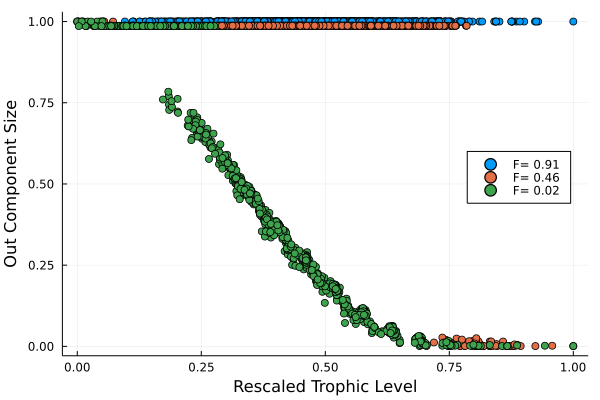

In [78]:


#Plotting out components 





plot(h_array[:,3]/maximum(h_array[:,3]), out_comp_array[:,3]/N, seriestype = :scatter, legend = :right, xlabel= "Rescaled Trophic Level",

ylabel="Out Component Size", label = "F= $(round(F_list[3], digits=2))")


plot!(h_array[:,2]/maximum(h_array[:,2]), out_comp_array[:,2]/N, seriestype = :scatter, legend = true, xlabel= "Rescaled Trophic Level",

ylabel="Out Component Size", label = "F= $(round(F_list[2], digits=2))")



plot!(h_array[:,1]/maximum(h_array[:,1]), out_comp_array[:,1]/N, seriestype = :scatter, legend = :right, xlabel= "Rescaled Trophic Level",

ylabel="Out Component Size", label = "F= $(round(F_list[1], digits=2))")

#savefig("Out_componests_N1000_k_10.pdf")

In [10]:
using Plots

#histogram(diffs, xlabel= "Level Differences", ylabel="Frequency", title=(string("N=1000 k=10 F=",  string(round(F,digits = 3) ))))

#savefig("Generated_Level_distribution_high.pdf")

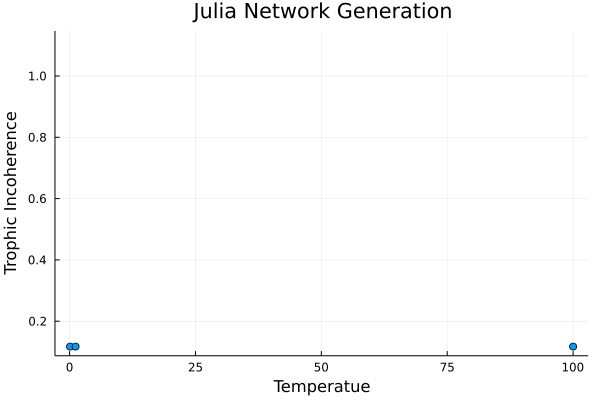

In [11]:
using Plots

plot(T_list,F_list, seriestype = :scatter, legend = false, xlabel= "Temperatue",

ylabel="Trophic Incoherence", title= "Julia Network Generation")

#savefig("Julia_generation_2.pdf")

In [12]:

using Polynomials, SpecialFunctions

x=F_list

y= num_diff_list


plot(F_list, num_diff_list, seriestype = :scatter, legend = :topleft, xlabel= "Trophic Incoherence",

ylabel="Fraction of Negative Edges", title= "Fraction of Negative Edges", label= "Networks")



F_plot= LinRange(0, 1, 1000)


arg= - sqrt.(-F_plot .+1)./(F_plot*(2)) 

erf_function= 0.5*(1 .+ erf.(arg))

plot!(F_plot,  erf_function , label= "ERF Approx", lw=3)

#quadfit=Polynomials.fit(x,y,1)
#plot!(quadfit,x[1],x[end],label="Linear Fit", lw = 3)

#savefig("Error_function_approx_negative_edges_generated.pdf")


DivideError: DivideError: integer division error

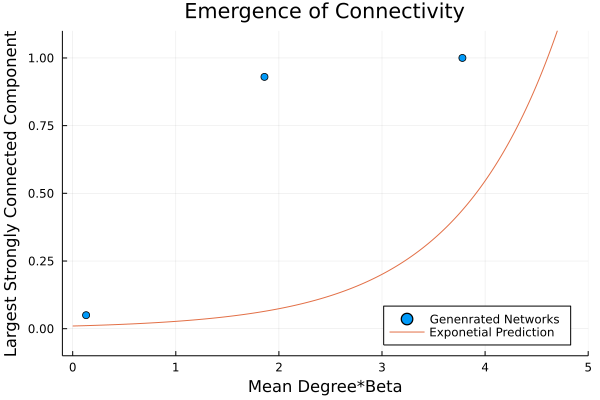

In [32]:
#plot(( -num_diff_list.^-1 .+ L_targ/N) , mean_strong_list/N,legend=false,seriestype = :scatter,ylabel="Mean Strongly Connected Component", xlabel="Mean Degree - 1/Beta",title="Emergence of Connectivity")

#plot(( num_diff_list*L_targ/N ) , mean_strong_list/N,legend=false,seriestype = :scatter,ylabel="Mean Strongly Connected Component", xlabel="Mean Degree*Beta",title="Emergence of Connectivity")


F_plot= LinRange(0, 10, 1000)


#F_plot= LinRange(0.000001, 10, 1000)

plot(( num_diff_list*L_targ/N ) , strong_list,legend=:bottomright,seriestype = :scatter,ylabel="Largest Strongly Connected Component", xlabel="Mean Degree*Beta",title="Emergence of Connectivity" ,label="Genenrated Networks")

#plot!(sign.(F_plot), F_plot .-5, ylim=(-0.1,1.1), linestyle=:dash, label="Critical Point") 
plot!(F_plot, exp.(F_plot)/N, ylim=(-0.1,1.1),xlim=(-0.1,5), label="Exponetial Prediction") 
    
    
#savefig("EXP_undershoots_Connectivity_Generated_Degree_Beta_N_100.pdf")

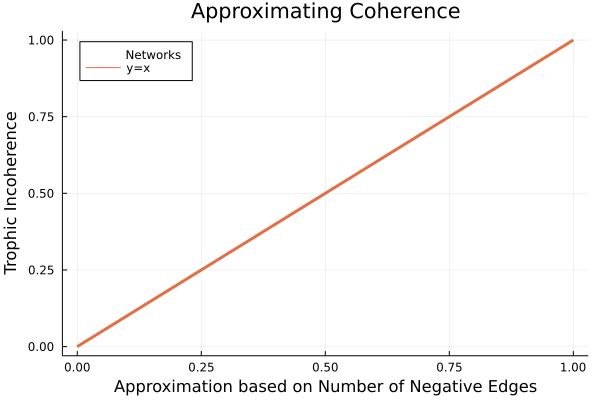

In [14]:
y= F_list

#x = 2*num_diff_list.*avg_diffs .- avg_diffs .+ 1

x =   -avg_diffs2  .+1

line= LinRange(0, 1, 1000)

plot(line,line)

plot(x, y, seriestype = :scatter, legend = legend = :topleft, ylabel= "Trophic Incoherence",

xlabel="Approximation based on Number of Negative Edges", title= "Approximating Coherence", label= "Networks")


plot!(line,line, label="y=x", lw = 3)



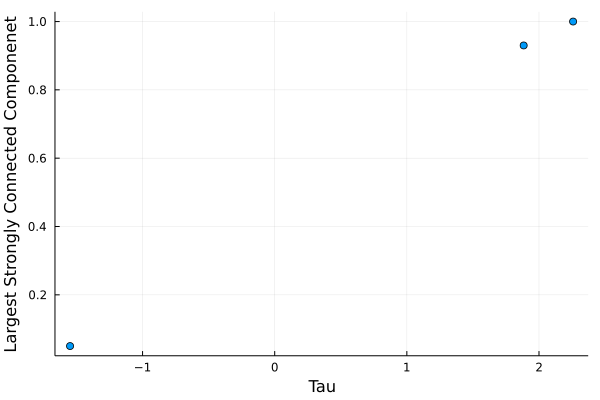

In [33]:
plot((tau_list), strong_list, seriestype = :scatter, legend=:false, ylabel="Largest Strongly Connected Componenet"

,xlabel= "Tau")
#println(strong_list)
#savefig("tau_largest_strong_component.pdf")

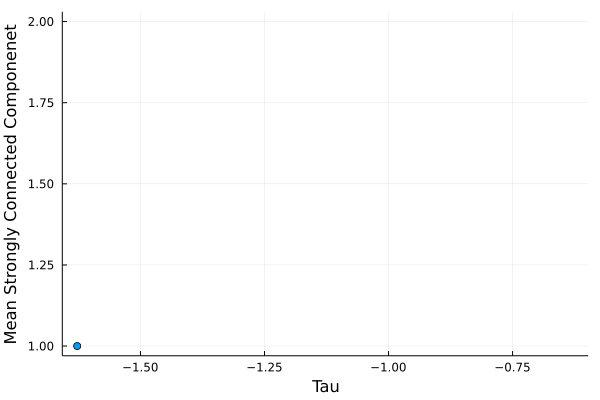

In [16]:
plot((tau_list), mean_strong_list, seriestype = :scatter, legend=:false, ylabel="Mean Strongly Connected Componenet"

,xlabel= "Tau")


#savefig("tau_mean_strong_component.pdf")

In [17]:
using StatsBase


using LaTeXStrings

F_round= round(mean(F_list),digits=3 )

tau_round= round(mean(tau_list),digits=3 )

#histogram(x , normalize = true, seriestype = :scatter,  yaxis=:log, xaxis=:log )

#using StatsBase, Plots
#hist = (StatsBase.fit(Histogram, x))
#Plots.plot((hist))

d = countmap(sizes)
#println( pweights(x))

x = collect(keys(d))/N

y= collect(values(d))/N/number

Plots.plot(log10.(x), log10.(y) , seriestype=:scatter,legend=false , label="Networks Generated",
    

ylabel= "No. of Stongly connected Componenets", xlabel="Size of Strongly Connected Component", title =" Mean F= $F_round Mean tau = $tau_round")

#line= LinRange(0.1, 1, 1000)

#quadfit=Polynomials.fit((x),(y),1)
#plot!(quadfit,x[1],x[end],label="Linear Fit", lw = 3, xlim=(1/N -0.1*(1/N) ,1.1),xaxis=:log,yaxis=:log )

using CurveFit


p = sortperm(x)

#print(x)

x = x[p]

y=  y[p]

x= x[2:30]

y=y[2:30]

a,b = linear_fit(log10.(x), log10.(y))


println(a,b)
xlim=(1/N -0.1*(1/N),1.1)

ylim= (0.0001,1)

b_round= round(b,digits=3)

plot!(log10.(line), log10.(line)*b .+a, label="Linear Fit exponent $b_round", lw = 3 , legend=true)


#savefig("GRS3_Strong_distrubution__low_tau_test_very_dependent_on_size_Tau.pdf")

LoadError: BoundsError: attempt to access 3-element Vector{Float64} at index [2:30]

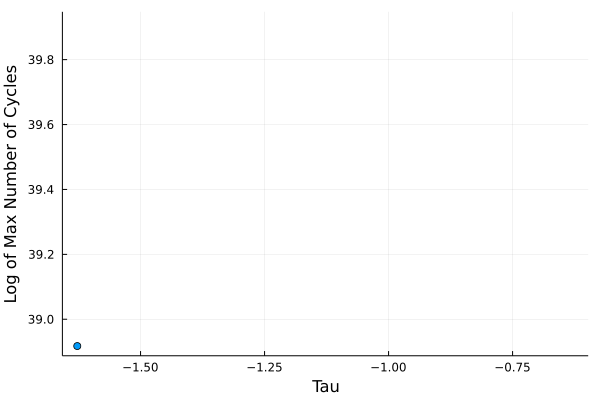

In [18]:
plot(tau_list, log10.(max_cycle_list),seriestype = :scatter,legend=false, xlabel="Tau", ylabel="Log of Max Number of Cycles")


#savefig("N_30_cycles_tau.pdf")

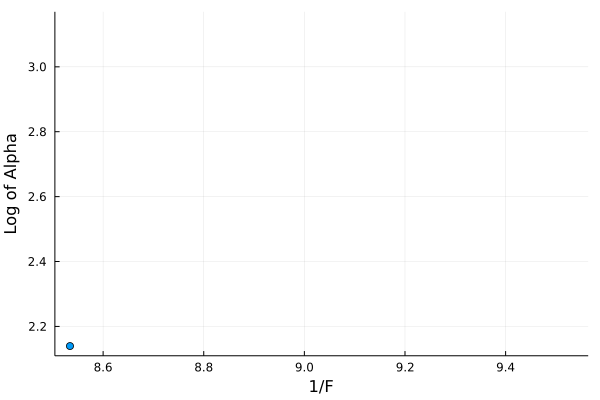

In [19]:
plot(F_list.^-1,log.(alpha_list), seriestype = :scatter, legend=false, ylabel="Log of Alpha", xlabel="1/F")

#savefig("Log_alpha_versus_1_over_F.pdf")

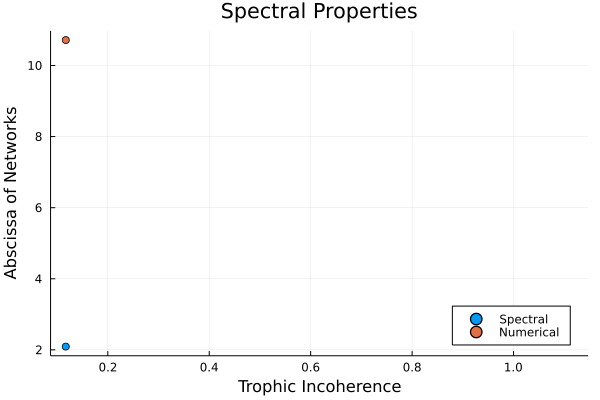

In [20]:
#println(eig_list)

plot(F_list, eig_list, seriestype = :scatter, legend = :bottomright, xlabel= "Trophic Incoherence",

ylabel="Abscissa of Networks", title= "Spectral Properties", label= "Spectral" )

plot!(F_list, eig_list_num_abs, seriestype = :scatter, label = "Numerical")
#savefig("Abscissa_of_Networks.pdf")

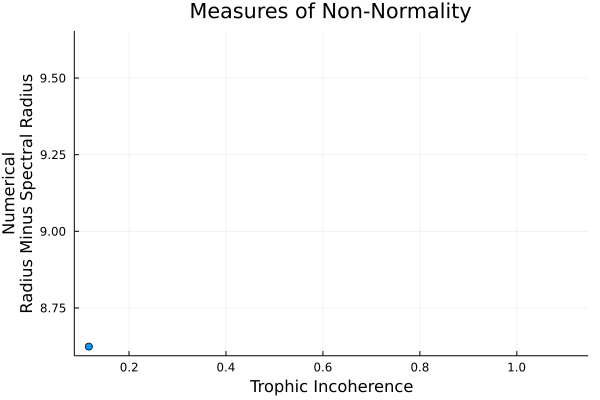

In [21]:
plot(F_list, eig_list_num_abs -eig_list , seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="Numerical
Radius Minus Spectral Radius", title= "Measures of Non-Normality")
#savefig("Other_Non_normality_measure_Networks.pdf")

In [22]:
#plot(F_list, (cond_list), seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",
    #ylabel="Conidtion Number" , yaxis=:log)

#savefig("Condition_number_N_500.png")

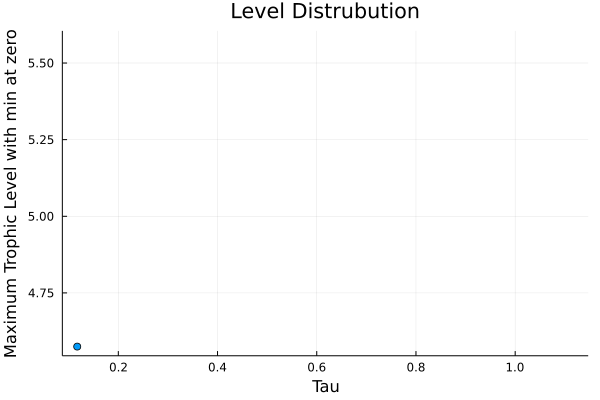

In [23]:
plot(F_list, h_max_list, seriestype = :scatter, legend = false, xlabel= "Tau",

ylabel="Maximum Trophic Level with min at zero", title= "Level Distrubution", label= "Spectral" )

#savefig("tau_Maximum_Level_Numerical_Networks.pdf")



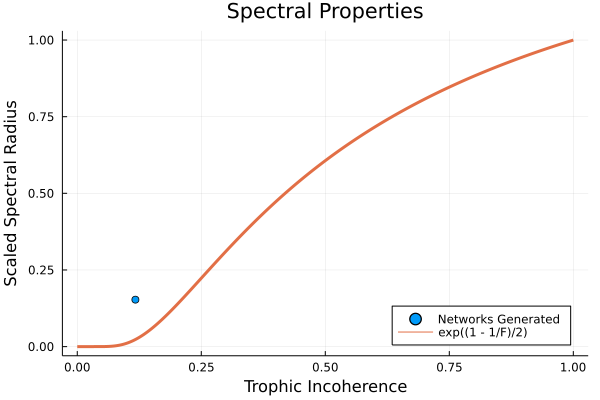

In [24]:
plot(F_list, scale_spec_list, seriestype = :scatter, legend = :bottomright, xlabel= "Trophic Incoherence",

ylabel="Scaled Spectral Radius", title= "Spectral Properties", label= "Networks Generated" )

F_plot= LinRange(0, 1, 1000)

plot!(F_plot,  exp.(((1 .- 1 ./ F_plot))/2), label= "exp((1 - 1/F)/2)", lw=3)

#savefig("scaled_spec_radius_test.pdf")

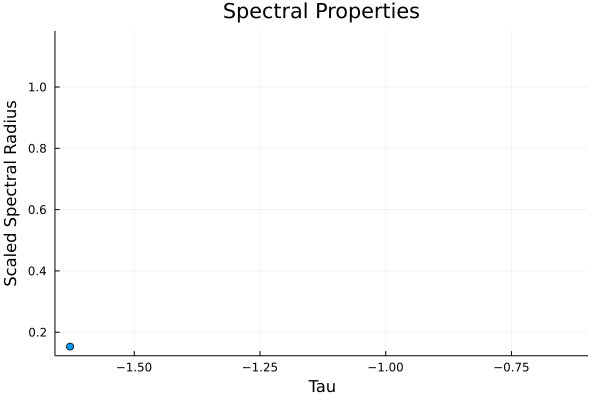

In [25]:
plot((tau_list), scale_spec_list, seriestype = :scatter,  xlabel= "Tau",

ylabel="Scaled Spectral Radius", title= "Spectral Properties", label= "Networks Generated" ,legend=:false )

#F_plot= LinRange(0, 1, 1000)

#plot!(F_plot,  exp.(((1 .- 1 ./ F_plot))/2), label= "exp((1 - 1/F)/2)", lw=3)

#savefig("sign_tau_scaled_spec_radius.pdf")

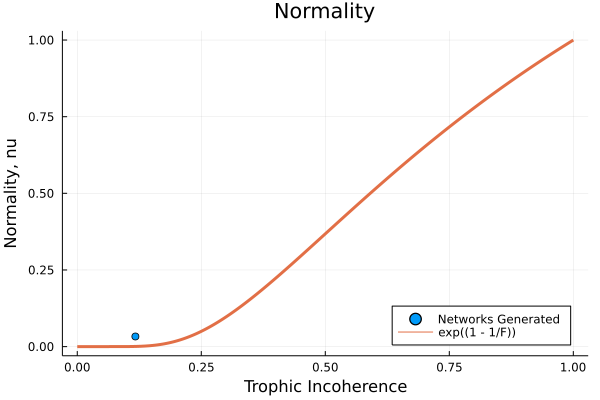

In [26]:
plot(F_list, nu_normal_list, seriestype = :scatter, legend = :bottomright, xlabel= "Trophic Incoherence",

ylabel="Normality, nu", title= "Normality", label= "Networks Generated" )



plot!(F_plot,  exp.(((1 .- 1 ./ F_plot))), label= "exp((1 - 1/F))", lw=3)

#savefig("nu_normlity_test_dense.pdf")

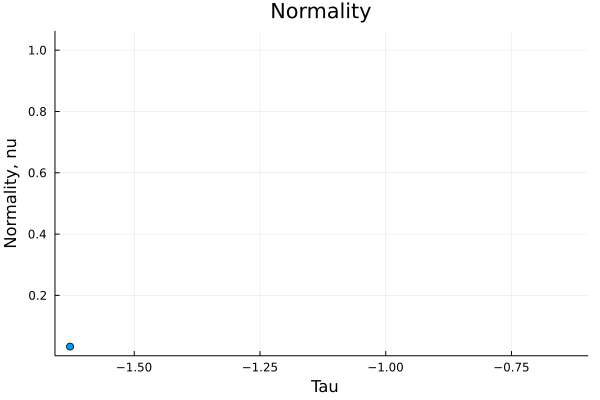

In [27]:
plot((tau_list), nu_normal_list, seriestype = :scatter, legend = :false, xlabel= " Tau",

ylabel="Normality, nu", title= "Normality", label= "Networks Generated" )



#plot!(F_plot,  exp.(((1 .- 1 ./ F_plot))), label= "exp((1 - 1/F))", lw=3)

#savefig("normality_tau_sign.pdf")

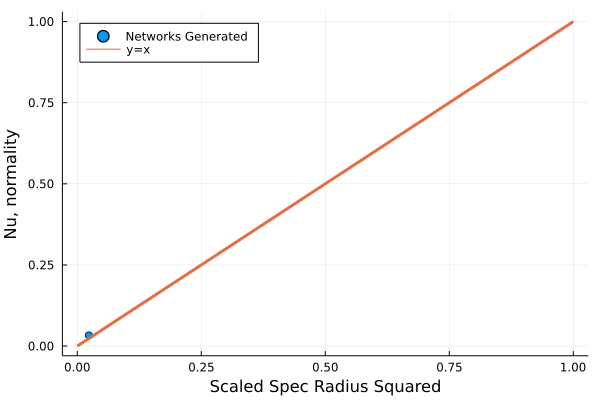

In [28]:
plot(scale_spec_list.^2 , nu_normal_list, seriestype = :scatter, label= "Networks Generated", legend = :topleft, xlabel="Scaled Spec Radius Squared"

,ylabel = "Nu, normality")

plot!(line,line, label="y=x", lw = 3)

#savefig("nu_normlity_analysis_dense.pdf")

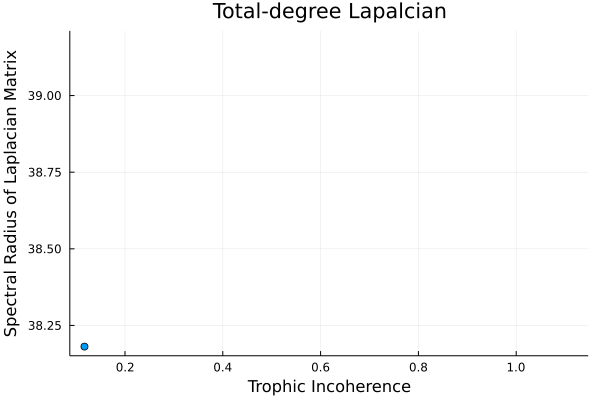

In [29]:
plot(F_list, lap_spec_list, seriestype = :scatter, legend=:false, xlabel="Trophic Incoherence", ylabel = "Spectral Radius of Laplacian Matrix", title ="Total-degree Lapalcian")


#savefig("total_lapacian_test.pdf")

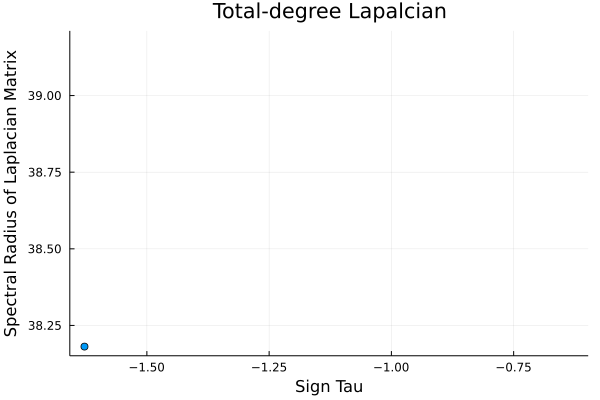

In [30]:
plot((tau_list), lap_spec_list, seriestype = :scatter, legend=:false, xlabel="Sign Tau", ylabel = "Spectral Radius of Laplacian Matrix", title ="Total-degree Lapalcian")


#savefig("sign_tau_total_lapacian_test.pdf")


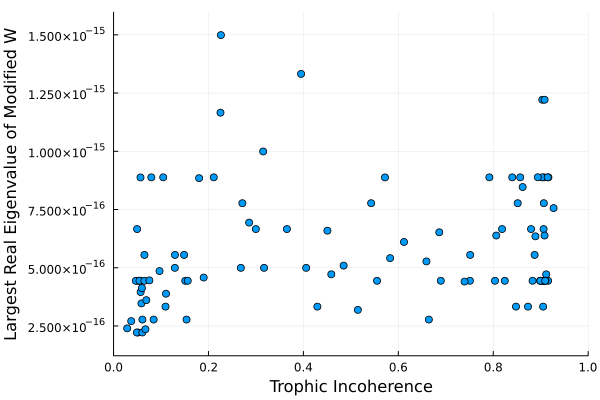

In [125]:
plot(F_list, J_max_list, seriestype = :scatter, xlims = (0,1) ,legend=:false, xlabel="Trophic Incoherence", ylabel="Largest Real Eigenvalue of Modified W")
#savefig("Modified_W.pdf")

In [126]:
pseudo_spec

plot(F_list, pseudo_spec, seriestype = :scatter, legend = :false, xlabel= "Trophic Incoherence",

ylabel="Pseudo Spectral Radius", )


DivideError: DivideError: integer division error

In [127]:


using LaTeXStrings

plot(F_list, ((pseudo_spec -eig_list)/ϵ), seriestype = :scatter, legend = :false, xlabel= "Trophic Incoherence",

ylabel=L" \frac {\rho_\epsilon(A) - \rho(A)}{\epsilon} " ,yaxis=:log )


#savefig("Pseduo_spec_data.pdf")

LoadError: DimensionMismatch("dimensions must match: a has dims (Base.OneTo(0),), b has dims (Base.OneTo(100),), mismatch at 1")

In [128]:
using LaTeXStrings

plot(tau_list, ((pseudo_spec -eig_list)/ϵ), seriestype = :scatter, legend = :false, xlabel= "Tau",

ylabel=L" \frac {\rho_\epsilon(A) - \rho(A)}{\epsilon} " ,yaxis=:log )


#savefig("Tau_Pseduo_spec_data.pdf")

LoadError: DimensionMismatch("dimensions must match: a has dims (Base.OneTo(0),), b has dims (Base.OneTo(100),), mismatch at 1")

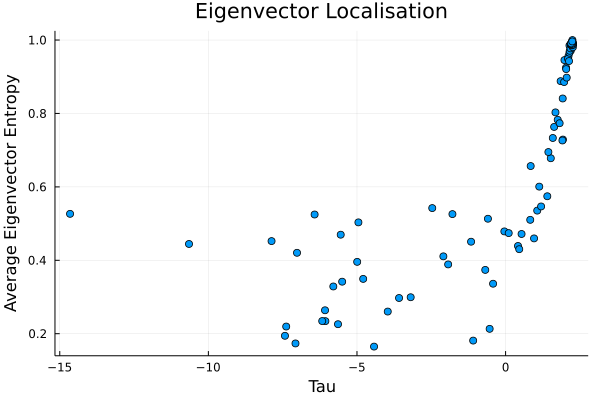

In [129]:
plot((tau_list), entropy_list/maximum(entropy_list), seriestype = :scatter,legend=false ,xlabel= "Tau",

ylabel="Average Eigenvector Entropy",title="Eigenvector Localisation")

#savefig("Log_Tau_Entropy_Eigenvector_localisation.pdf")

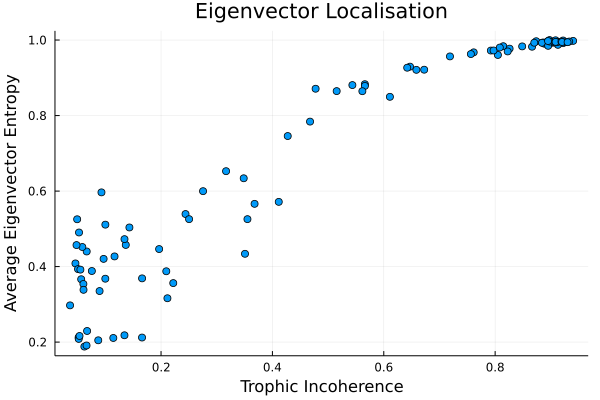

In [153]:
plot(F_list, entropy_list/maximum(entropy_list), seriestype = :scatter,legend=false ,xlabel= "Trophic Incoherence",

ylabel="Average Eigenvector Entropy",title="Eigenvector Localisation")

#savefig("Entropy_Eigenvector_localisation_N500.png")

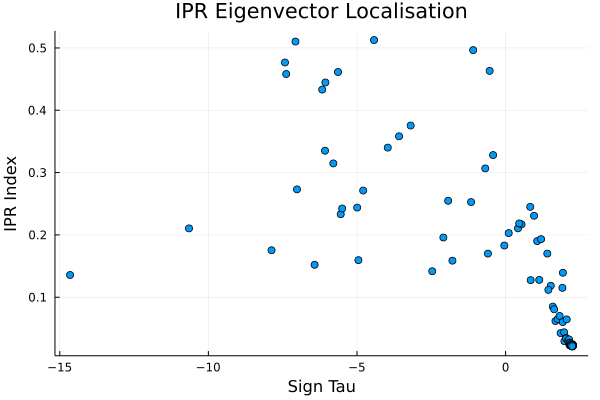

In [131]:
plot((tau_list), (ipr_list), seriestype = :scatter,legend=false ,xlabel= "Sign Tau",

ylabel="IPR Index",title="IPR Eigenvector Localisation" )

#savefig("Log_Tau_IPR_localisation_IPR.pdf")

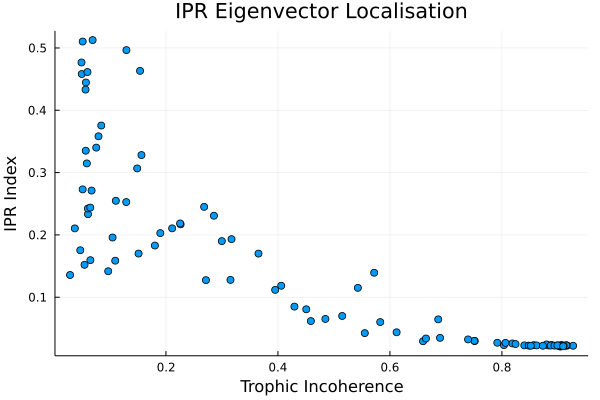

In [132]:
plot(F_list, (ipr_list), seriestype = :scatter,legend=false ,xlabel= "Trophic Incoherence",

ylabel="IPR Index",title="IPR Eigenvector Localisation" )

#savefig("IPR_localisation_IPR_500.png")

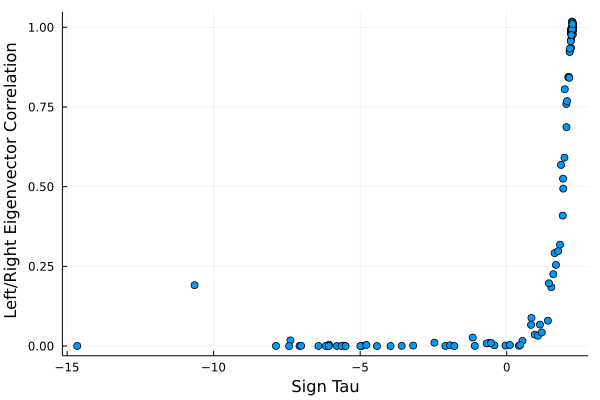

In [133]:
plot((tau_list), corr_list, seriestype = :scatter,legend=false ,xlabel= "Sign Tau",

ylabel=" Left/Right Eigenvector Correlation" )



#savefig("Log_Tau_Eigenvector_corrleation_1.pdf")

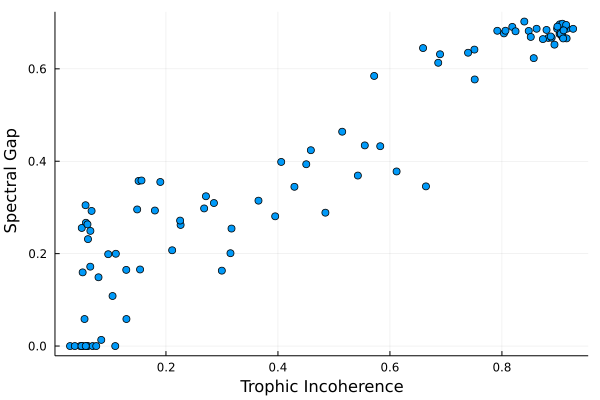

In [134]:
plot(F_list, gap_list, seriestype = :scatter,legend=false ,xlabel= "Trophic Incoherence",

ylabel=" Spectral Gap")

#savefig("Spectral_Gap_N_500_scaled_new.png")

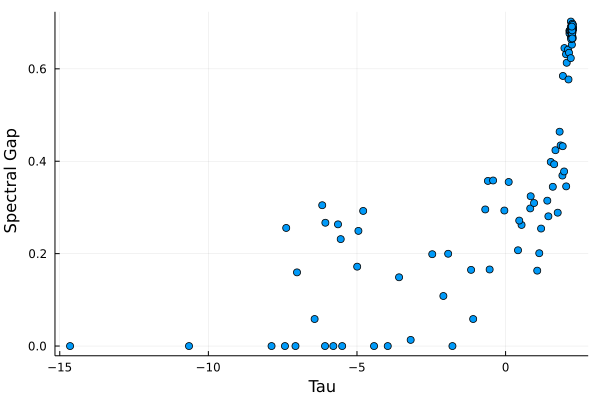

In [135]:
plot((tau_list), gap_list, seriestype = :scatter,legend=false ,xlabel= "Tau",

ylabel=" Spectral Gap")

#savefig("Sign_Tau_Spectral_Gap_N_500_scaled_new.pdf")

In [136]:
#plot(h_dist_list,h_eig_list , seriestype = :scatter,legend=false ,xlabel= "Trophic Level of Node scaled by max level",

#ylabel="  Principle Eigenvector of Node", title= "High Incoherence F approx 0.95")

#savefig("Principle_eigenvector_levels_high_incoherence.png")




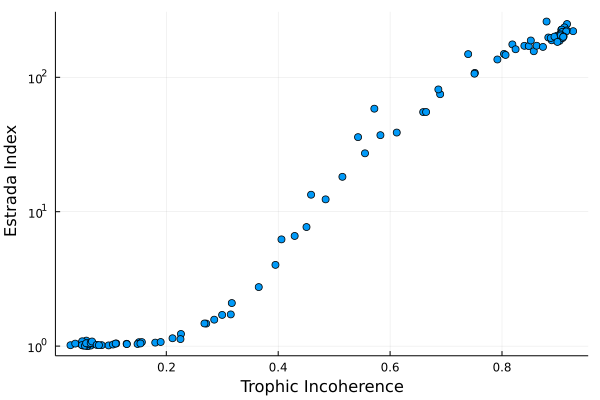

In [137]:
plot(F_list, EE_list/N, seriestype = :scatter,legend=false ,xlabel= "Trophic Incoherence",

ylabel=" Estrada Index", yaxis=:log)

#savefig("EE_Index_log_N_500.png")

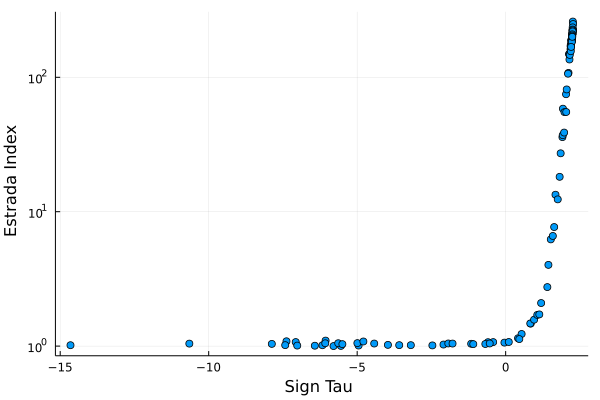

In [138]:
plot((tau_list), EE_list/N, seriestype = :scatter,legend=false ,xlabel= "Sign Tau ",

ylabel=" Estrada Index",yaxis=:log)

#savefig("Sign_Tau_Estrada_Index.pdf")

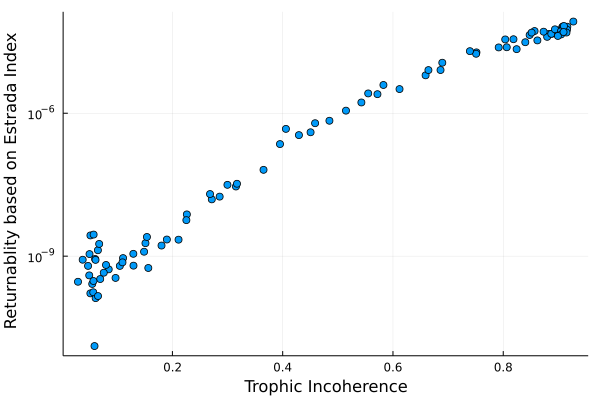

In [139]:
plot(F_list, return_list, seriestype = :scatter,legend=false ,xlabel= "Trophic Incoherence",

ylabel=" Returnablity based on Estrada Index", yaxis=:log)

#savefig("Returnablity_index_N500_k_10.pdf")

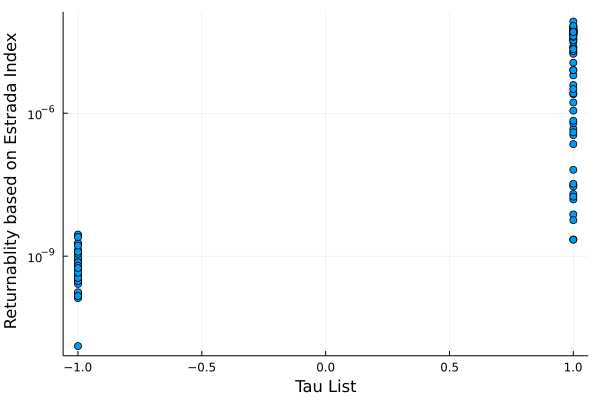

In [140]:
plot(sign.(tau_list), return_list, seriestype = :scatter,legend=false ,xlabel= "Tau List",

ylabel=" Returnablity based on Estrada Index", yaxis=:log)

#savefig("Sign_Tau_Returnablity_index.pdf")

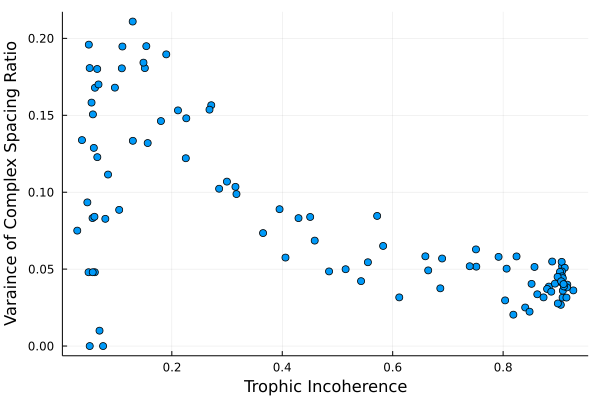

In [141]:
plot(F_list, spacing_list, seriestype = :scatter,legend=false ,xlabel= "Trophic Incoherence",

ylabel="Varaince of Complex Spacing Ratio")

#savefig("Varaince_Spacing_ratio_spacing_ratio.pdf")

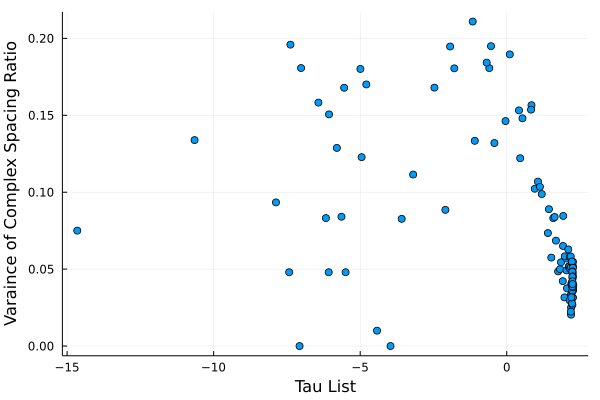

In [142]:
plot(tau_list, spacing_list, seriestype = :scatter,legend=false ,xlabel= "Tau List",

ylabel="Varaince of Complex Spacing Ratio"  )

#savefig("Tau_Varaince_Spacing_ratio_spacing_ratio.pdf")

In [143]:
plot(tau_list, clustering_list,seriestype = :scatter, ylabel="Clustering Coefficient" ,xlabel="Tau",legend=false)


#savefig("Clustering_coefficent_tau.pdf")

DivideError: DivideError: integer division error

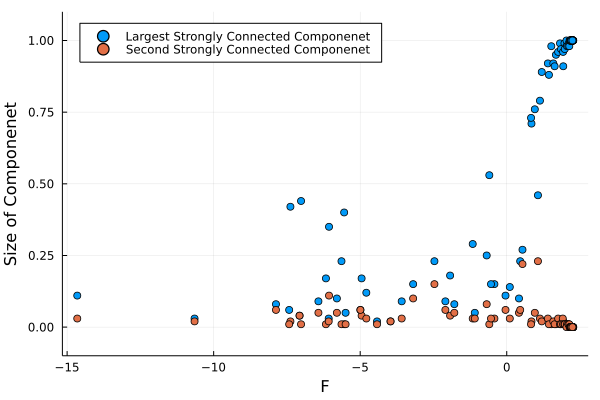

In [144]:
plot(tau_list, strong_list, seriestype = :scatter, label="Largest Strongly Connected Componenet",legend=:topleft,ylim=(-0.1,1.1))

plot!(tau_list, second_strong_list, seriestype = :scatter, label="Second Strongly Connected Componenet", xlabel="F", ylabel="Size of Componenet")

#savefig("Second_largest_component_generated_tau_N_500.pdf")


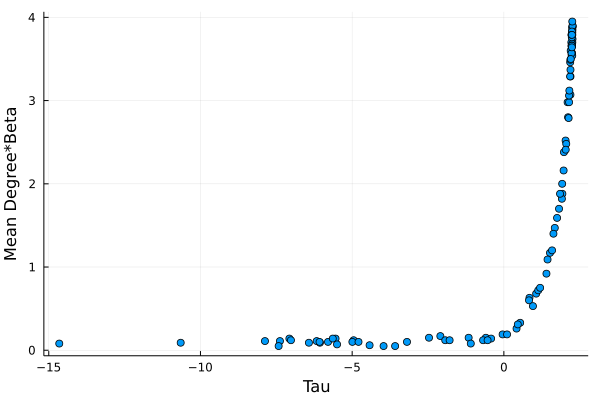

In [145]:
plot(tau_list, ( num_diff_list*L_targ/N) , seriestype = :scatter, xlabel="Tau", ylabel="Mean Degree*Beta", label=false)

#savefig("generated_mean_degree_tau.pdf")

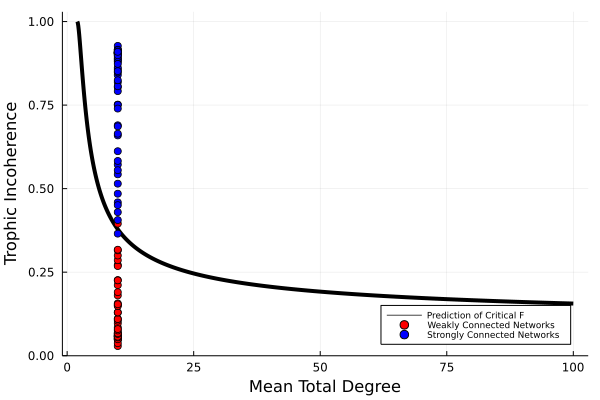

In [146]:
x_plot= LinRange(2, 100, 1000)


L_s= zeros(0)

L_w = zeros(0)

F_s =  zeros(0)

F_w =zeros(0)


for a in 1:(size(F_list)[1])
    
    
    if strong_list[a]>0.9
    
    #append!(L_s, L_targ_list[a]/N)
    append!(L_s, L_targ/N)
    append!(F_s, F_list[a])
        
    
        else 
        
        
        
        #append!(L_w, L_targ_list[a]/N)
        append!(L_w, L_targ/N)
        append!(F_w, F_list[a])
    end
    end 


plot(x_plot,  (1 .+ 2*((erfinv.(2*((x_plot).^-1) .-1)).^2)).^-1,lw=4, label="Prediction of Critical F", color="black", ylabel="Trophic Incoherence", xlabel="Mean Total Degree")


plot!(L_w,F_w, seriestype = :scatter, label="Weakly Connected Networks",color="red")
plot!(L_s,F_s, seriestype = :scatter, label="Strongly Connected Networks", color="blue",  legendfontsize=6, legend=:bottomright)
#savefig("Critical_F_connectivty_artificial_2.pdf")

In [148]:


plot(F_list, pr_ent_list, seriestype = :scatter, xlabel="Trophic Incoherence", ylabel="Entropy of PageRank",label=false)

#savefig("PageRank_Entropy_test_2.pdf")
